<a href="https://colab.research.google.com/github/jmershov/SureStartFutureMakers/blob/main/Day_16_Gender_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from IPython.display import display
import plotly.express as px
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, experimental, MaxPool2D, BatchNormalization
from tensorflow.keras.losses import sparse_categorical_crossentropy, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau 
from tensorflow.data import Dataset
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.random import set_seed
from tensorflow.keras.utils import to_categorical
from tensorflow import test
import random

In [2]:
np.random.seed(11)
set_seed(11)
random.seed(11)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
df = pd.read_csv('/content/gdrive/MyDrive/Dataset/age_gender.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


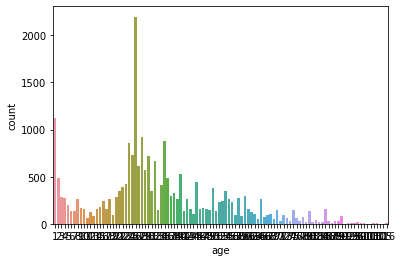

In [5]:
sns.countplot(x='age', data=df)

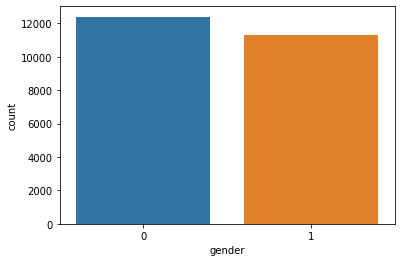

In [6]:
sns.countplot(x='gender', data=df)

In [7]:
df = df[df['age'] >= 13]
df.reset_index(drop=True, inplace=True)
df

,age,ethnicity,gender,img_name,pixels
0,100,0,0,20170112213500903.jpg.chip.jpg,203 185 139 163 176 184 186 175 175 156 159 13...
1,100,0,0,20170112215240346.jpg.chip.jpg,125 126 115 78 66 66 77 85 95 102 117 138 138 ...
2,100,0,1,20170110183726390.jpg.chip.jpg,235 164 113 144 121 201 243 237 234 221 233 23...
3,100,0,1,20170112213001988.jpg.chip.jpg,82 82 82 82 82 82 84 86 90 85 104 105 102 154 ...
4,100,0,1,20170112213303693.jpg.chip.jpg,70 72 94 149 154 166 175 169 172 161 176 187 2...
...,...,...,...,...,...
20287,99,0,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
20288,99,1,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
20289,99,2,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
20290,99,2,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...


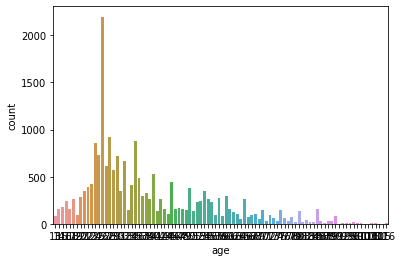

In [8]:
sns.countplot(x='age', data=df)

In [9]:
df.isnull().sum()

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

In [10]:
num_pixels = len(df['pixels'][0].split(' '))
dimension = int(np.sqrt(num_pixels))
img_width = dimension
img_height = dimension
print("Pixels: {}".format(num_pixels))
print("Width: {0}, Height: {1}".format(img_width, img_height))

Pixels: 2304
Width: 48, Height: 48


In [11]:
X_img = df.iloc[:, 4].copy()
y_age = df.iloc[:,0].copy()
y_ethnicity = df.iloc[:,1].copy()
y_gender = df.iloc[:,2].copy()

X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_img, y_gender, test_size=0.3, random_state=11)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.15, random_state=11)

def str_to_npArr(x):
    x = x.reset_index(drop=True)
    x = x.apply(lambda x: np.array(x.split(), dtype="float32"))
    return np.array([x[i].reshape(img_width, img_height, 1) for i in range(x.shape[0])])

X_train = str_to_npArr(X_train)
X_test = str_to_npArr(X_test)
X_val = str_to_npArr(X_val)

print("Target: shape = (16593, 48, 48, 1), type = <class 'numpy.ndarray'>")
print("Current: shape = {}, type = {}".format(X_train.shape, type(X_train)))

Target: shape = (16593, 48, 48, 1), type = <class 'numpy.ndarray'>
Current: shape = (14204, 48, 48, 1), type = <class 'numpy.ndarray'>


In [12]:
target_columns = ['gender', 'ethnicity', 'age']

data_preprocess = df.drop('img_name', axis=1)
y = data_preprocess[target_columns]
X = data_preprocess.drop(target_columns, axis=1)

print(X)
print("--------------------------------------------------------")
print(y)

                                                  pixels
0      203 185 139 163 176 184 186 175 175 156 159 13...
1      125 126 115 78 66 66 77 85 95 102 117 138 138 ...
2      235 164 113 144 121 201 243 237 234 221 233 23...
3      82 82 82 82 82 82 84 86 90 85 104 105 102 154 ...
4      70 72 94 149 154 166 175 169 172 161 176 187 2...
...                                                  ...
20287  127 100 94 81 77 77 74 99 102 98 128 145 160 1...
20288  23 28 32 35 42 47 68 85 98 103 113 117 130 129...
20289  59 50 37 40 34 19 30 101 156 170 177 184 187 1...
20290  45 108 120 156 206 197 140 180 191 199 204 207...
20291  156 161 160 165 170 173 166 177 183 191 187 18...

[20292 rows x 1 columns]
--------------------------------------------------------
       gender  ethnicity  age
0           0          0  100
1           0          0  100
2           1          0  100
3           1          0  100
4           1          0  100
...       ...        ...  ...
20287       1          

In [13]:
X = X['pixels'].apply(lambda x: np.array(x.split(), dtype="float32")) 
X = np.array(X) / 255.0
X = np.array([ X[i].reshape(48,48,1) for i in range(X.shape[0]) ])

print("Traget: X Shape: {}".format(X.shape))
print("Current: X Shape: {}".format(X.shape))

Traget: X Shape: (20292, 48, 48, 1)
Current: X Shape: (20292, 48, 48, 1)


In [14]:
y_gender = np.array(y['gender'])
y_age = np.array(y['age'])
y_ethnicity = np.array(y['ethnicity'])

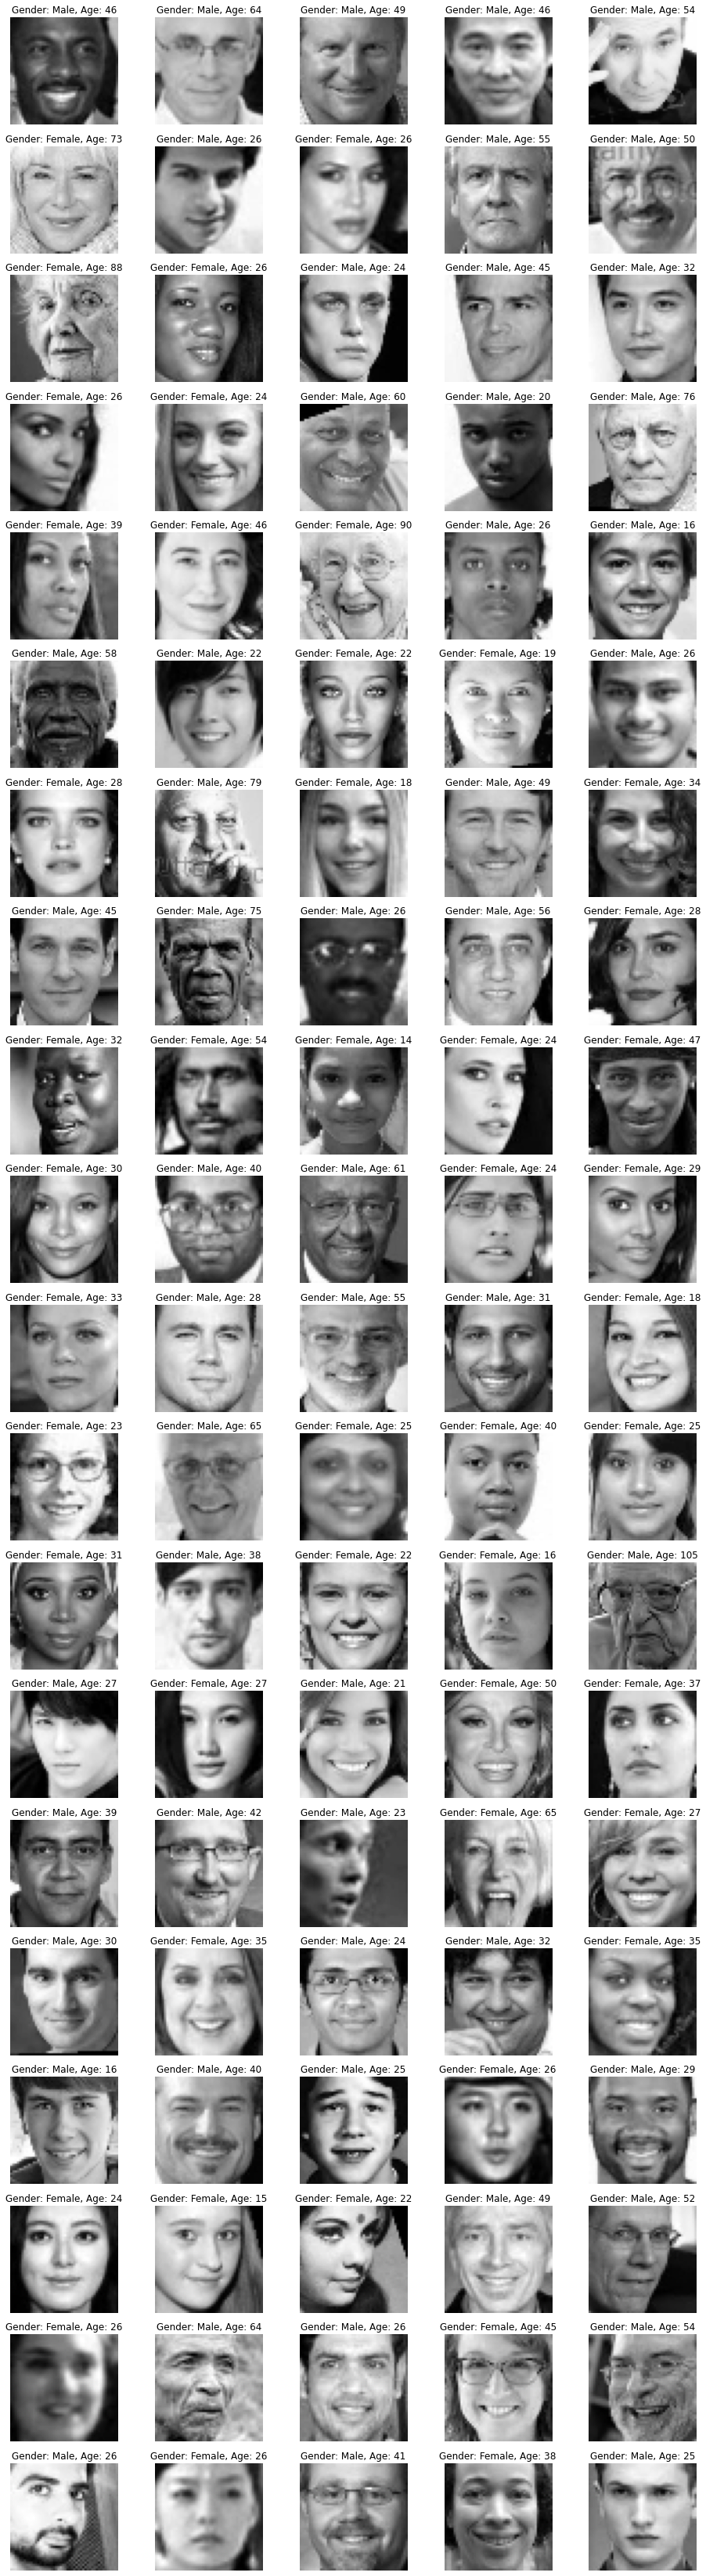

In [15]:
rows = 20 
cols = 5 
samp = random.sample(range(X.shape[0]),rows*cols) 
x_samp = X[samp,:,:,:]
y_samp_gender = y_gender[samp]
y_samp_age = y_age[samp]
    
fig,ax = plt.subplots(rows,cols,figsize=(16,60))
r = 0
c = 0   

for i in range(rows*cols):
    aa = x_samp[i,:,:,:].reshape(48,48)
    ax[r,c].axis("off")
    ax[r,c].imshow(aa,cmap="gray")
    ax[r,c].set_title(f"Gender: {'Female' if y_samp_gender[i]==1 else 'Male'}, Age: {y_samp_age[i]}")
    c+=1
    if c == cols:
        c=0
        r+=1
        
plt.show()

In [16]:
train_data_gen = ImageDataGenerator(rotation_range=30, width_shift_range=1, brightness_range=[0.8,1.2], zoom_range=[0.8,1.2], rescale=1/255)
val_data_gen = ImageDataGenerator(rescale=1/255)
test_data_gen = ImageDataGenerator(rescale=1/255)

In [17]:
set_seed(11)
random.seed(11)
np.random.seed(11)

val_data = val_data_gen.flow(X_val, Y_val, seed=11,shuffle=False)
test_data = test_data_gen.flow(X_test,Y_test, seed=11,shuffle=False)

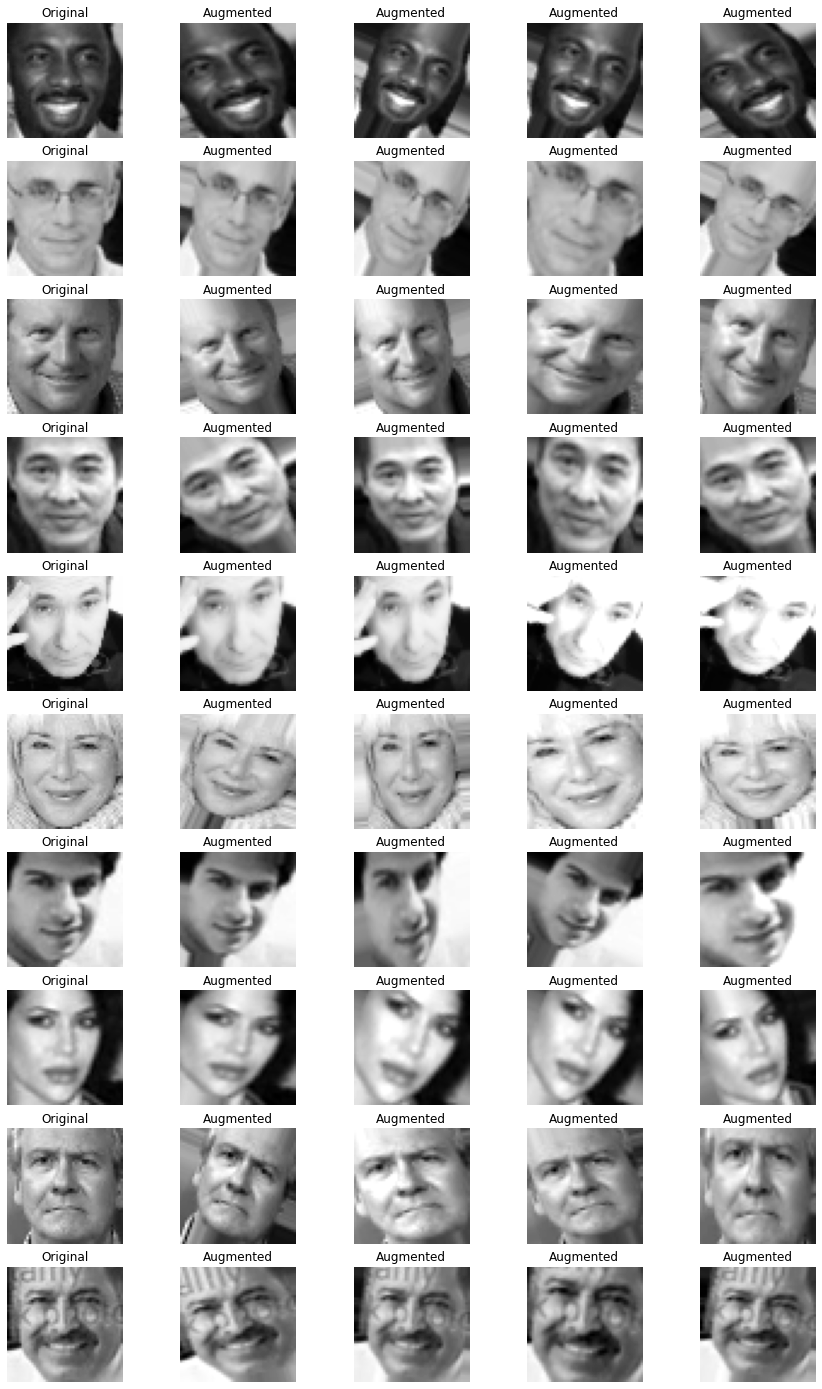

In [18]:
fig,ax = plt.subplots(10,5,figsize=(15,25))
for n in range(10):    
    r = random.sample(range(X.shape[0]),1)[0]
    ax[n,0].imshow(X[r].reshape(48,48),cmap="gray")
    ax[n,0].set_title("Original")
    ax[n,0].axis("off")
    for i in range(1,5):
        ax[n,i].imshow(train_data_gen.random_transform(X[r]).reshape(48,48),cmap="gray")
        ax[n,i].set_title("Augmented")
        ax[n,i].axis("off")
plt.show()

In [19]:
batch_size = 32
loss_function = sparse_categorical_crossentropy
no_classes = 2
no_epochs = 50
optimizer = Adam()
verbosity = 1
num_folds = 10
activation='softmax'

input_shape = (48, 48, 1)
input_shape

(48, 48, 1)

In [20]:
random.seed(11)
set_seed(11)
np.random.seed(11)

kfold = KFold(n_splits=num_folds, shuffle=True)

In [21]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

fold_no = 1
for train, test in kfold.split(X, y_gender):
    
  random.seed(11)
  set_seed(11)
  np.random.seed(11)
  
  model = Sequential()
  
  model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(BatchNormalization())

  model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())

  model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())

  model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(128, activation='softmax'))

  model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])

  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
    
  early_stop = EarlyStopping(monitor="val_loss",patience=5,mode="min") # Ensure the model doesn't overfit
  
  # Set Seed
  random.seed(11)
  set_seed(11)
  np.random.seed(11)
    
  # Fit data to model
  history = model.fit(train_data_gen.flow(X[train], y_gender[train], seed=11),
            callbacks=early_stop,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_data=train_data_gen.flow(X[test], y_gender[test],
                                   seed=11))
  fig = px.line(
  history.history, y=['loss', 'val_loss'],
  labels={'index': 'epoch', 'value': 'loss'}, 
  title='Training History')
  fig.show()
    
  scores = model.evaluate(train_data_gen.flow(X[test], y_gender[test],
                                   seed=11), verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
571/571 [==============================] - 49s 29ms/step - loss: 0.5404 - accuracy: 0.7782 - val_loss: 0.9387 - val_accuracy: 0.6365
Epoch 2/50
571/571 [==============================] - 16s 28ms/step - loss: 0.3304 - accuracy: 0.8598 - val_loss: 0.3204 - val_accuracy: 0.8591
Epoch 3/50
571/571 [==============================] - 15s 26ms/step - loss: 0.2989 - accuracy: 0.8784 - val_loss: 0.4494 - val_accuracy: 0.7961
Epoch 4/50
571/571 [==============================] - 15s 26ms/step - loss: 0.2723 - accuracy: 0.8905 - val_loss: 0.3482 - val_accuracy: 0.8527
Epoch 5/50
571/571 [==============================] - 16s 27ms/step - loss: 0.2605 - accuracy: 0.8965 - val_loss: 0.2537 - val_accuracy: 0.8975
Epoch 6/50
571/571 [==============================] - 16s 28ms/step - loss: 0.2447 - accuracy: 0.9030 - val_loss: 0.2159 - val_accuracy: 0.9212
Epoch 7/50
571/571 [===================

Score for fold 1: loss of 0.1796826720237732; accuracy of 93.15270781517029%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/50
571/571 [==============================] - 18s 29ms/step - loss: 0.6035 - accuracy: 0.7254 - val_loss: 0.4549 - val_accuracy: 0.7911
Epoch 2/50
571/571 [==============================] - 16s 29ms/step - loss: 0.3826 - accuracy: 0.8358 - val_loss: 0.5479 - val_accuracy: 0.7567
Epoch 3/50
571/571 [==============================] - 16s 28ms/step - loss: 0.3357 - accuracy: 0.8586 - val_loss: 0.3163 - val_accuracy: 0.8685
Epoch 4/50
571/571 [==============================] - 15s 26ms/step - loss: 0.3062 - accuracy: 0.8749 - val_loss: 0.2783 - val_accuracy: 0.8897
Epoch 5/50
571/571 [==============================] - 15s 26ms/step - loss: 0.2846 - accuracy: 0.8856 - val_loss: 0.2982 - val_accuracy: 0.8892
Epoch 6/50
571/571 [==============================] - 16s 28ms/step - loss: 0.2674 - accuracy: 0.8935 - va

Score for fold 2: loss of 0.2160366028547287; accuracy of 92.41379499435425%
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/50
571/571 [==============================] - 16s 27ms/step - loss: 0.6034 - accuracy: 0.7243 - val_loss: 0.5104 - val_accuracy: 0.7472
Epoch 2/50
571/571 [==============================] - 15s 25ms/step - loss: 0.3857 - accuracy: 0.8340 - val_loss: 0.4557 - val_accuracy: 0.7827
Epoch 3/50
571/571 [==============================] - 16s 28ms/step - loss: 0.3275 - accuracy: 0.8625 - val_loss: 0.3089 - val_accuracy: 0.8684
Epoch 4/50
571/571 [==============================] - 16s 28ms/step - loss: 0.2976 - accuracy: 0.8772 - val_loss: 0.2943 - val_accuracy: 0.8783
Epoch 5/50
571/571 [==============================] - 15s 25ms/step - loss: 0.2833 - accuracy: 0.8846 - val_loss: 0.3053 - val_accuracy: 0.8743
Epoch 6/50
571/571 [==============================] - 14s 25ms/step - loss: 0.2620 - accuracy: 0.8962 - va

Score for fold 3: loss of 0.20353762805461884; accuracy of 92.26219654083252%
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/50
571/571 [==============================] - 16s 26ms/step - loss: 0.6156 - accuracy: 0.7079 - val_loss: 0.5676 - val_accuracy: 0.6885
Epoch 2/50
571/571 [==============================] - 15s 26ms/step - loss: 0.4063 - accuracy: 0.8246 - val_loss: 0.3981 - val_accuracy: 0.8354
Epoch 3/50
571/571 [==============================] - 16s 29ms/step - loss: 0.3347 - accuracy: 0.8623 - val_loss: 0.3349 - val_accuracy: 0.8531
Epoch 4/50
571/571 [==============================] - 15s 27ms/step - loss: 0.3029 - accuracy: 0.8735 - val_loss: 0.2859 - val_accuracy: 0.8857
Epoch 5/50
571/571 [==============================] - 15s 26ms/step - loss: 0.2764 - accuracy: 0.8884 - val_loss: 0.2771 - val_accuracy: 0.8847
Epoch 6/50
571/571 [==============================] - 14s 25ms/step - loss: 0.2630 - accuracy: 0.8946 - v

Score for fold 4: loss of 0.2182389795780182; accuracy of 91.42434597015381%
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/50
571/571 [==============================] - 16s 26ms/step - loss: 0.5820 - accuracy: 0.7383 - val_loss: 0.4931 - val_accuracy: 0.7467
Epoch 2/50
571/571 [==============================] - 14s 25ms/step - loss: 0.3714 - accuracy: 0.8409 - val_loss: 0.3464 - val_accuracy: 0.8472
Epoch 3/50
571/571 [==============================] - 16s 28ms/step - loss: 0.3272 - accuracy: 0.8620 - val_loss: 0.2982 - val_accuracy: 0.8827
Epoch 4/50
571/571 [==============================] - 16s 27ms/step - loss: 0.2952 - accuracy: 0.8824 - val_loss: 0.2973 - val_accuracy: 0.8797
Epoch 5/50
571/571 [==============================] - 15s 25ms/step - loss: 0.2755 - accuracy: 0.8880 - val_loss: 0.2615 - val_accuracy: 0.8975
Epoch 6/50
571/571 [==============================] - 14s 25ms/step - loss: 0.2574 - accuracy: 0.8974 - va

Score for fold 5: loss of 0.21322210133075714; accuracy of 92.01577305793762%
------------------------------------------------------------------------
Training for fold 6 ...
Epoch 1/50
571/571 [==============================] - 16s 27ms/step - loss: 0.6046 - accuracy: 0.7180 - val_loss: 0.6275 - val_accuracy: 0.6949
Epoch 2/50
571/571 [==============================] - 15s 27ms/step - loss: 0.3724 - accuracy: 0.8413 - val_loss: 0.3592 - val_accuracy: 0.8521
Epoch 3/50
571/571 [==============================] - 16s 29ms/step - loss: 0.3218 - accuracy: 0.8668 - val_loss: 0.3004 - val_accuracy: 0.8812
Epoch 4/50
571/571 [==============================] - 16s 28ms/step - loss: 0.2956 - accuracy: 0.8798 - val_loss: 0.3127 - val_accuracy: 0.8802
Epoch 5/50
571/571 [==============================] - 17s 30ms/step - loss: 0.2739 - accuracy: 0.8890 - val_loss: 0.2945 - val_accuracy: 0.8817
Epoch 6/50
571/571 [==============================] - 16s 29ms/step - loss: 0.2646 - accuracy: 0.8955 - v

Score for fold 6: loss of 0.16988876461982727; accuracy of 93.88861656188965%
------------------------------------------------------------------------
Training for fold 7 ...
Epoch 1/50
571/571 [==============================] - 16s 26ms/step - loss: 0.6167 - accuracy: 0.7062 - val_loss: 0.5425 - val_accuracy: 0.7373
Epoch 2/50
571/571 [==============================] - 15s 26ms/step - loss: 0.3743 - accuracy: 0.8384 - val_loss: 0.3727 - val_accuracy: 0.8344
Epoch 3/50
571/571 [==============================] - 17s 29ms/step - loss: 0.3230 - accuracy: 0.8632 - val_loss: 0.5031 - val_accuracy: 0.7324
Epoch 4/50
571/571 [==============================] - 16s 27ms/step - loss: 0.3012 - accuracy: 0.8773 - val_loss: 0.4028 - val_accuracy: 0.8172
Epoch 5/50
571/571 [==============================] - 15s 26ms/step - loss: 0.2832 - accuracy: 0.8859 - val_loss: 0.4281 - val_accuracy: 0.8068
Epoch 6/50
571/571 [==============================] - 15s 26ms/step - loss: 0.2657 - accuracy: 0.8931 - v

Score for fold 7: loss of 0.2459031492471695; accuracy of 89.65007662773132%
------------------------------------------------------------------------
Training for fold 8 ...
Epoch 1/50
571/571 [==============================] - 18s 30ms/step - loss: 0.5862 - accuracy: 0.7312 - val_loss: 0.5681 - val_accuracy: 0.6875
Epoch 2/50
571/571 [==============================] - 16s 27ms/step - loss: 0.3700 - accuracy: 0.8414 - val_loss: 0.3399 - val_accuracy: 0.8433
Epoch 3/50
571/571 [==============================] - 15s 27ms/step - loss: 0.3195 - accuracy: 0.8685 - val_loss: 0.3522 - val_accuracy: 0.8595
Epoch 4/50
571/571 [==============================] - 16s 29ms/step - loss: 0.2948 - accuracy: 0.8818 - val_loss: 0.3204 - val_accuracy: 0.8600
Epoch 5/50
571/571 [==============================] - 16s 29ms/step - loss: 0.2727 - accuracy: 0.8882 - val_loss: 0.2732 - val_accuracy: 0.8881
Epoch 6/50
571/571 [==============================] - 15s 27ms/step - loss: 0.2598 - accuracy: 0.8965 - va

Score for fold 8: loss of 0.2114124894142151; accuracy of 91.86791777610779%
------------------------------------------------------------------------
Training for fold 9 ...
Epoch 1/50
571/571 [==============================] - 17s 29ms/step - loss: 0.6153 - accuracy: 0.7169 - val_loss: 0.7218 - val_accuracy: 0.6343
Epoch 2/50
571/571 [==============================] - 16s 28ms/step - loss: 0.3826 - accuracy: 0.8355 - val_loss: 0.3874 - val_accuracy: 0.8354
Epoch 3/50
571/571 [==============================] - 16s 27ms/step - loss: 0.3282 - accuracy: 0.8637 - val_loss: 0.4044 - val_accuracy: 0.8305
Epoch 4/50
571/571 [==============================] - 15s 27ms/step - loss: 0.3058 - accuracy: 0.8746 - val_loss: 0.2978 - val_accuracy: 0.8714
Epoch 5/50
571/571 [==============================] - 16s 29ms/step - loss: 0.2786 - accuracy: 0.8868 - val_loss: 0.2758 - val_accuracy: 0.8921
Epoch 6/50
571/571 [==============================] - 17s 29ms/step - loss: 0.2679 - accuracy: 0.8916 - va

Score for fold 9: loss of 0.2224942147731781; accuracy of 91.27649068832397%
------------------------------------------------------------------------
Training for fold 10 ...
Epoch 1/50
571/571 [==============================] - 16s 27ms/step - loss: 0.6040 - accuracy: 0.7247 - val_loss: 0.7602 - val_accuracy: 0.5722
Epoch 2/50
571/571 [==============================] - 16s 29ms/step - loss: 0.3750 - accuracy: 0.8393 - val_loss: 0.4610 - val_accuracy: 0.7831
Epoch 3/50
571/571 [==============================] - 16s 28ms/step - loss: 0.3258 - accuracy: 0.8665 - val_loss: 0.4808 - val_accuracy: 0.7762
Epoch 4/50
571/571 [==============================] - 15s 26ms/step - loss: 0.3035 - accuracy: 0.8752 - val_loss: 0.2772 - val_accuracy: 0.8866
Epoch 5/50
571/571 [==============================] - 15s 26ms/step - loss: 0.2778 - accuracy: 0.8865 - val_loss: 0.2746 - val_accuracy: 0.8906
Epoch 6/50
571/571 [==============================] - 16s 29ms/step - loss: 0.2633 - accuracy: 0.8956 - v

Score for fold 10: loss of 0.2924237549304962; accuracy of 88.36865425109863%


In [23]:
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.1796826720237732 - Accuracy: 93.15270781517029%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.2160366028547287 - Accuracy: 92.41379499435425%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.20353762805461884 - Accuracy: 92.26219654083252%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.2182389795780182 - Accuracy: 91.42434597015381%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.21322210133075714 - Accuracy: 92.01577305793762%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.16988876461982727 - Accuracy: 93.88861656188965%
---------------------------------------------------------------------

In [24]:
random.seed(11)
set_seed(11)
np.random.seed(11)

model = Sequential()
  
model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='softmax'))

model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

In [26]:
Final_train = np.append(X_train, X_val, axis=0)
Final_val = np.append(Y_train, Y_val, axis=0)
final_training_data = train_data_gen.flow(Final_train, Final_val,
                                   seed=11)

random.seed(11)
set_seed(11)
np.random.seed(11)
final_model_history = model.fit(train_data_gen.flow(X, y_gender, seed=11),batch_size=32,epochs=20, validation_data=val_data)

Epoch 1/20
635/635 [==============================] - 18s 28ms/step - loss: 0.5964 - accuracy: 0.7233 - val_loss: 0.7019 - val_accuracy: 0.6264
Epoch 2/20
635/635 [==============================] - 16s 26ms/step - loss: 0.3811 - accuracy: 0.8354 - val_loss: 0.3008 - val_accuracy: 0.8742
Epoch 3/20
635/635 [==============================] - 16s 25ms/step - loss: 0.3264 - accuracy: 0.8648 - val_loss: 0.2643 - val_accuracy: 0.8906
Epoch 4/20
635/635 [==============================] - 16s 24ms/step - loss: 0.3026 - accuracy: 0.8748 - val_loss: 0.2716 - val_accuracy: 0.8954
Epoch 5/20
635/635 [==============================] - 17s 27ms/step - loss: 0.2755 - accuracy: 0.8891 - val_loss: 0.3245 - val_accuracy: 0.8775
Epoch 6/20
635/635 [==============================] - 17s 26ms/step - loss: 0.2564 - accuracy: 0.8972 - val_loss: 0.2079 - val_accuracy: 0.9211
Epoch 7/20
635/635 [==============================] - 17s 27ms/step - loss: 0.2467 - accuracy: 0.9012 - val_loss: 0.2078 - val_accuracy:

In [28]:
model.evaluate(test_data)

29/29 [==============================] - 0s 15ms/step - loss: 0.1349 - accuracy: 0.9508


[0.13489724695682526, 0.95076584815979]

In [30]:
y_pred = model.predict_classes(test_data)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       485
           1       0.97      0.92      0.95       429

    accuracy                           0.95       914
   macro avg       0.95      0.95      0.95       914
weighted avg       0.95      0.95      0.95       914



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



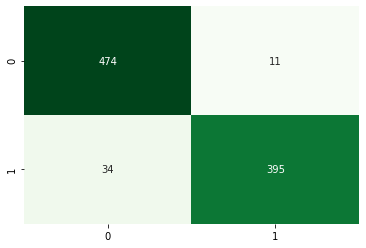

In [32]:
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, cmap='Greens', cbar=False, annot=True, fmt='d');